In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

In [3]:
# adjust the relative paths here
sys.path.append('../')
sys.path.append('../../../git/impy/') # impy: python interface for monte-carlo generators
sys.path.append('../../../git/m2m/')  # m2m: histogram class to convert monte-carlo output for matrix methods
#sys.path.append('../../../../Repos/impy/')
#sys.path.append('../../../../Repos/m2m/')
sys.path.append('../ParticleDataTool/') # Particle Data Tool

In [4]:
from impy.sophia import SophiaCascadeRun, SophiaCascadeEvent
from impy.common import EventKinematics
from m2m.histograms import EnergySpectrum

import ParticleDataTool

# Testing the Sophia event generator

### setup and convenience functions

In [5]:
def get_bins_and_width_from_centers(vector):

    vector_log = np.log10(vector)

    steps = vector_log[1] - vector_log[0]

    bins_log = vector_log - 0.5 * steps

    bins_log = np.resize(bins_log, vector_log.size + 1)

    bins_log[-1] = vector_log[-1] + 0.5 * steps

    bins = 10**bins_log

    widths = bins[1:] - bins[:-1]

    return bins, widths

In [7]:
centers = np.logspace(0,4,40)
print centers
print '-'*50
bins ,_ = get_bins_and_width_from_centers(centers)
print bins
print '-'*50
centers = (bins[1:] + bins [:-1]) / 2
print centers
print '-'*50
bins ,_ = get_bins_and_width_from_centers(centers)

print bins 
print '-'*50
centers = (bins[1:] + bins [:-1]) / 2
print centers
print '-'*50

[  1.00000000e+00   1.26638017e+00   1.60371874e+00   2.03091762e+00
   2.57191381e+00   3.25702066e+00   4.12462638e+00   5.22334507e+00
   6.61474064e+00   8.37677640e+00   1.06081836e+01   1.34339933e+01
   1.70125428e+01   2.15443469e+01   2.72833338e+01   3.45510729e+01
   4.37547938e+01   5.54102033e+01   7.01703829e+01   8.88623816e+01
   1.12533558e+02   1.42510267e+02   1.80472177e+02   2.28546386e+02
   2.89426612e+02   3.66524124e+02   4.64158883e+02   5.87801607e+02
   7.44380301e+02   9.42668455e+02   1.19377664e+03   1.51177507e+03
   1.91448198e+03   2.42446202e+03   3.07029063e+03   3.88815518e+03
   4.92388263e+03   6.23550734e+03   7.89652287e+03   1.00000000e+04]
--------------------------------------------------
[  8.88623816e-01   1.12533558e+00   1.42510267e+00   1.80472177e+00
   2.28546386e+00   2.89426612e+00   3.66524124e+00   4.64158883e+00
   5.87801607e+00   7.44380301e+00   9.42668455e+00   1.19377664e+01
   1.51177507e+01   1.91448198e+01   2.42446202e+01

In [5]:
# set up even generator
srun = SophiaCascadeRun('sophia12','Sophia',0,
                        10000, # events 
                        fill_subset=False)

# list of stable particles
ptab = srun.ptab
part_name = lambda ev: [ptab.modid2modname[pid] for pid in ev.p_ids]

stable_part = [ptab.modid2modname[pid] for pid in range(1,21) if pid != 12]
stable_ids = [pid for pid in range(1,21) if pid != 12]

sophia12
stable, 1
stable, 2
stable, 3
stable, 4
stable, 5
stable, 6
stable, 7
stable, 8
stable, 9
stable, 10
stable, 11
stable, 13
stable, 14
stable, 15
stable, 16
stable, 17
stable, 18
stable, 19
stable, 20
SophiaCascadeRun::init_generator(): seed= 3492575


In [46]:
def set_up_hists(stable_ids, e_mother = 1e6):
    """
    sets up histograms for all particles that are set stable in the sophia interface
    """
    
    h_list = []

    for stable_id in stable_ids:
        h_list.append(
            EnergySpectrum(
                stable_id, ptab.modid2pdg[stable_id],
                e_mother, 'x', 
                title='some random title',
                x_bins=get_bins_and_width_from_centers(np.logspace(-5,0,120))[0]))
#                 x_bins=np.logspace(-5,0,120)))
#                 x_bins=np.linspace(0,1,120)))

        if stable_id in ptab.baryon_range:
            h_list.append(EnergySpectrum(
                -stable_id, ptab.modid2pdg[-stable_id],
                e_mother, 'x', 
                title='some random title',
                x_bins=get_bins_and_width_from_centers(np.logspace(-5,0,120))[0]))
#                 x_bins=np.logspace(-5,0,120)))
#                 x_bins=np.linspace(0,1,120)))
    
    return h_list

In [47]:
def run_sophia(mother_id, epsilon, theta = 180., e_mother = 1e6, n_events = 100000, rand_theta = False ):
    """
    Runs n_events with sophia and returns the resulting histogram
    """
    masses = {
    2212: 0.93827,
    2112: 0.93957
    }
    mass = masses[mother_id]
    y = e_mother * epsilon / mass
    e_rest =  y - y * np.cos(np.pi * theta / 180.)
    print 'rest frame photon energy: {:} GeV, with y = {:} and eps/Ep = {:}'.format(e_rest,y, epsilon/e_mother)
    s = 2 * mass * e_rest + mass**2
    print 'center of mass: s = {:}, gamma_s = {:}'.format(s, (e_mother + epsilon) / np.sqrt(s))
    
    srun.spectrum_hists = set_up_hists(stable_ids, e_mother = e_mother)
    srun.nEvents = n_events
    print 'running {:} events for particle {:}'.format(n_events, ptab.pdg2modname[mother_id])
    print '--'*10
    srun.start(mother_id, e_mother, epsilon, theta, rand_theta = rand_theta)#, rand_theta = True)
    
    return srun.spectrum_hists

In [48]:
def plot_redistribution(h_list, pids_plot = [2212,2112]):
    """
    plots the redistributions from h_list for all particles in pids_plot
    """
    for h in h_list:
        bin_centers = 0.5*(h.x_bins[1:] + h.x_bins[:-1])
        if h.pdg_id in pids_plot:
            plt.loglog(bin_centers, h.get(), label = ptab.pdg2modname[h.pdg_id])
    plt.legend()
    plt.xlabel('energy fraction of the primary proton $x$')
    plt.ylabel(r'redistibution $\frac{d n}{d x}$')
    
def print_multiplicities(h_list, pids_print = None):
    """
    prints multiplicities and total energy, to check energy and quantum number conservation
    """
    
    etotal = 0.
    baryon_number = 0.
    for h in h_list:
        bin_widths = (h.x_bins[1:] - h.x_bins[:-1])
        bin_center = 0.5 * (h.x_bins[1:] + h.x_bins[:-1])
        particles = h.get().dot(bin_widths)
        energy = (h.get() * bin_center).dot(bin_widths)
        if particles > 0.1:
            if pids_print and h.pdg_id not in pids_print:
                pass
            else:
                print 'p_id', h.pdg_id, ptab.pdg2modname[h.pdg_id]
                print 'multiplicity:', particles
                print 'energy fraction:', energy
                print '--'*10
        etotal += energy
        if h.pdg_id in [2212,2112]:
            baryon_number += particles
        if h.pdg_id in [-2212,-2112]:
            baryon_number -= particles
    print 'baryon number:', baryon_number
    print 'energy conservation:', etotal

### fixed $\epsilon_r$ with varying collision angle $\theta$

In the case, that the CM-frame is highly lorentz boosted, the redistribution in energy should not depend in the collision angle. i.e. for fixed $\epsilon_r$ the redistribution should be invariant under changing the angle.

This is tested here.

It seems, that the redistribution flips at smaller angles (70 deg here, but this depends in $E_p$ and $\epsilon$.
This is a numerical problem, as the lorentz boost to the rest frame gets numerically instable at smaller angels. This can invert the outgoing proton direction.

We can ignore this problem, as long as we sample at high $E_p$ and for heads-on collision

In [49]:
n_events = 100000
e_mother = 1. * 1e5

angle = 180.
epsilon = 1e1 / e_mother * 2. / (1 - np.cos(np.pi * angle / 180.))
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212])
#print_multiplicities(hlist)

angle = 90.
epsilon = 1e1 / e_mother * 2. / (1 - np.cos(np.pi * angle / 180.))
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212])
#print_multiplicities(hlist)

angle = 71.
epsilon = 1e1 / e_mother * 2. / (1 - np.cos(np.pi * angle / 180.))
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212])
#print_multiplicities(hlist)

plt.xscale('linear')

plt.show()
angle = 70.
epsilon = 1e1 / e_mother * 2. / (1 - np.cos(np.pi * angle / 180.))
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212])
#print_multiplicities(hlist)

angle = 30.
epsilon = 1e1 / e_mother * 2. / (1 - np.cos(np.pi * angle / 180.))
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212])
#print_multiplicities(hlist)

angle = 1.
epsilon = 1e1 / e_mother * 2. / (1 - np.cos(np.pi * angle / 180.))
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212])
#print_multiplicities(hlist)

plt.xscale('linear')
#plt.xlim(1e-1,1e0)

rest frame photon energy: 21.315825935 GeV, with y = 10.6579129675 and eps/Ep = 1e-09
center of mass: s = 40.8803505929, gamma_s = 15640.2141266
running 100000 events for particle p
--------------------


KeyboardInterrupt: 

### Different primary energies $E_p$ but constant $\epsilon_r$

This test is similar to the angle. The redistribution in $x = \frac{E_s}{E_p}$ should not depend in the primary energy $E_p$ as long as the CM_frame is strongly bosted and $\epsilon_r$ does not vary

Distribution universal for sufficient high energies

At low $ E_p$ the approximation breaks down (as expected). 

$E_p \geq 10^6$ should be save to use

In [ ]:
n_events = 100000
angle = 180.

e_mother = 1e6
epsilon = 4e1 / e_mother
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212,2112])
#print_multiplicities(hlist)
plt.show()

e_mother = 1e4
epsilon = 4e1 / e_mother
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212,2112])
#print_multiplicities(hlist)
plt.show()

e_mother = 1e3
epsilon = 4e1 / e_mother
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212,2112])
#print_multiplicities(hlist)
plt.show()

e_mother = 1e2
epsilon = 4e1 / e_mother
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212,2112])
#print_multiplicities(hlist)
plt.show()

e_mother = 1e1
epsilon = 4e1 / e_mother
hlist = run_sophia(2212, epsilon, theta = angle, n_events = n_events, e_mother = e_mother)
plot_redistribution(hlist, pids_plot=[2212,2112])
#print_multiplicities(hlist)
plt.show()

#plt.xlim(1e-1,1e0)

### Distribution at different energy regions

The following test are for illustration. The redistribution is in different energy regions

In [ ]:
n_events = 100000

# at the delta resonance
epsilon = 1.5e-7
angle = 180.

hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
print_multiplicities(hlist, pids_print = [2212,2112,-2212,-2112])

plot_redistribution(hlist)
plt.show()
plot_redistribution(hlist, pids_plot = [211,-211,111])
plt.show()


# at high energy (multipion)
epsilon = 2e-5
angle = 180.

hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
print_multiplicities(hlist, pids_print = [2212,2112,-2212,-2112])

plot_redistribution(hlist)
plt.show()
plot_redistribution(hlist, pids_plot = [211,-211,111])
plt.show()


# even higher energy (multipion)
epsilon = 1e-3
angle = 180.

hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
print_multiplicities(hlist, pids_print = [2212,2112,-2212,-2112])

plot_redistribution(hlist)
plt.show()
plot_redistribution(hlist, pids_plot = [211,-211,111])
plt.show()


rest frame photon energy: 21.315825935 GeV, with y = 10.6579129675 and eps/Ep = 1e-11
center of mass: s = 40.8803505929, gamma_s = 156402.141112
running 100000 events for particle p
--------------------


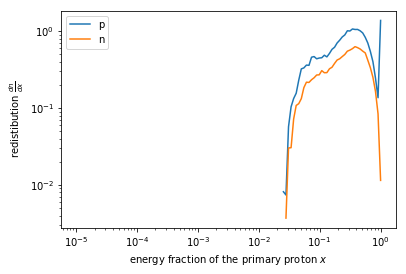

rest frame photon energy: 213.15825935 GeV, with y = 106.579129675 and eps/Ep = 1e-10
center of mass: s = 400.880350593, gamma_s = 49945.068749
running 100000 events for particle p
--------------------


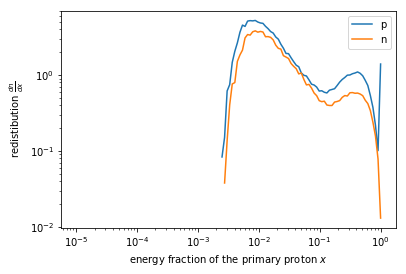

rest frame photon energy: 2131.5825935 GeV, with y = 1065.79129675 and eps/Ep = 1e-09
center of mass: s = 4000.88035059, gamma_s = 15809.6486582
running 100000 events for particle p
--------------------


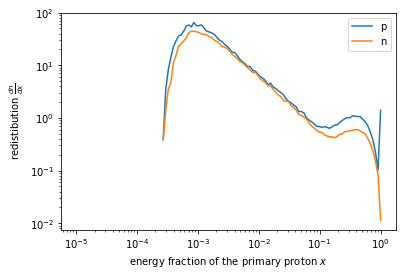

rest frame photon energy: 21315.825935 GeV, with y = 10657.9129675 and eps/Ep = 1e-08
center of mass: s = 40000.8803506, gamma_s = 4999.945029
running 100000 events for particle p
--------------------


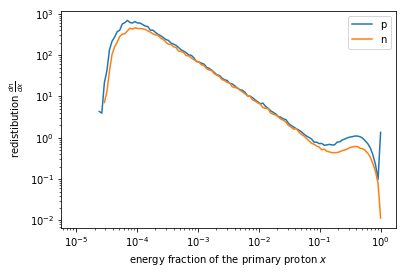

rest frame photon energy: 213158.25935 GeV, with y = 106579.129675 and eps/Ep = 1e-07
center of mass: s = 400000.880351, gamma_s = 1581.13724826
running 100000 events for particle p
--------------------


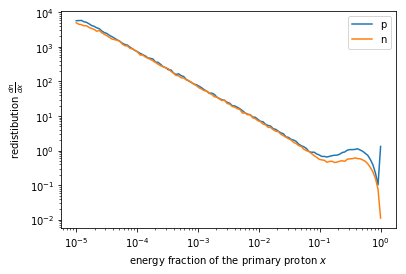

rest frame photon energy: 2131582.5935 GeV, with y = 1065791.29675 and eps/Ep = 1e-06
center of mass: s = 4000000.88035, gamma_s = 500.000444978
running 100000 events for particle p
--------------------


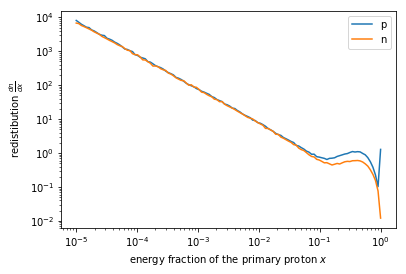

rest frame photon energy: 21315825.935 GeV, with y = 10657912.9675 and eps/Ep = 1e-05
center of mass: s = 40000000.8804, gamma_s = 158.115462407
running 100000 events for particle p
--------------------


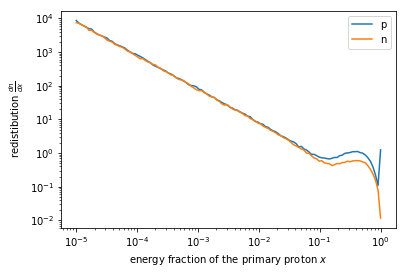

rest frame photon energy: 213158259.35 GeV, with y = 106579129.675 and eps/Ep = 0.0001
center of mass: s = 400000000.88, gamma_s = 50.004999945
running 100000 events for particle p
--------------------


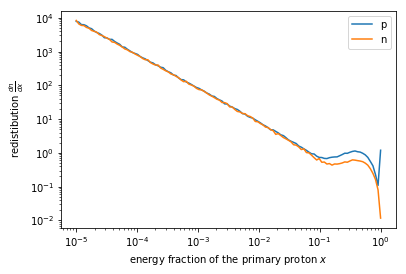

In [50]:
n_events = 100000

epsilon = 1e-5
angle = 180.
hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
plot_redistribution(hlist)
plt.show()

epsilon = 1e-4
angle = 180.
hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
plot_redistribution(hlist)
plt.show()

epsilon = 1e-3
angle = 180.
hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
plot_redistribution(hlist)
plt.show()

epsilon = 1e-2
angle = 180.
hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
plot_redistribution(hlist)
plt.show()

epsilon = 1e-1
angle = 180.
hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
plot_redistribution(hlist)
plt.show()

epsilon = 1e0
angle = 180.
hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
plot_redistribution(hlist)
plt.show()

epsilon = 1e1
angle = 180.
hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
plot_redistribution(hlist)
plt.show()

epsilon = 1e2
angle = 180.
hlist = run_sophia(2212, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
plot_redistribution(hlist)
plt.show()

### Also for neutron primaries

rest frame photon energy: 0.319294996647 GeV, with y = 0.159647498324 and eps/Ep = 1.5e-13
center of mass: s = 1.4827917849, gamma_s = 821220.750203
running 100000 events for particle n
--------------------
p_id 2212 p
multiplicity: 0.45877
energy fraction: 0.37602244666
--------------------
p_id 2112 n
multiplicity: 0.54123
energy fraction: 0.429253718064
--------------------
baryon number: 1.0
energy conservation: 1.00260642346


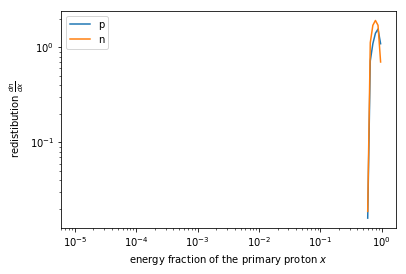

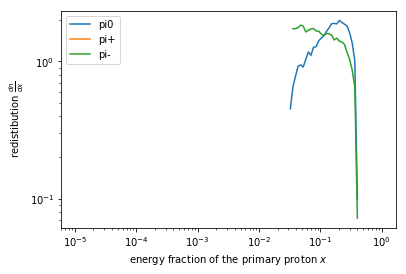

rest frame photon energy: 42.5726662197 GeV, with y = 21.2863331098 and eps/Ep = 2e-11
center of mass: s = 80.8827917849, gamma_s = 111191.588185
running 100000 events for particle n
--------------------
p_id 2212 p
multiplicity: 0.38087
energy fraction: 0.148393711132
--------------------
p_id 2112 n
multiplicity: 0.75827
energy fraction: 0.390360795859
--------------------
baryon number: 1.0
energy conservation: 0.996098811937


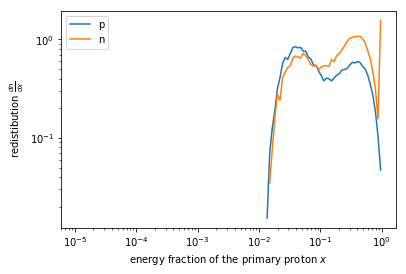

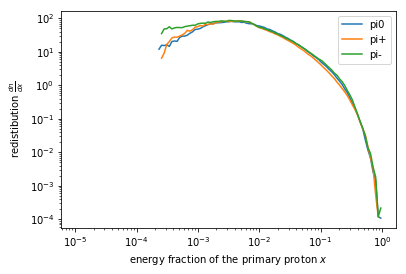

rest frame photon energy: 2128.63331098 GeV, with y = 1064.31665549 and eps/Ep = 1e-09
center of mass: s = 4000.88279178, gamma_s = 15809.6438349
running 100000 events for particle n
--------------------
p_id 2212 p
multiplicity: 0.66802
energy fraction: 0.158411537149
--------------------
p_id -2212 p-bar
multiplicity: 0.34992
energy fraction: 0.0126101047424
--------------------
p_id 2112 n
multiplicity: 1.0049
energy fraction: 0.3846914169
--------------------
p_id -2112 n-bar
multiplicity: 0.32302
energy fraction: 0.0130856512352
--------------------
baryon number: 0.99998
energy conservation: 0.995246719987


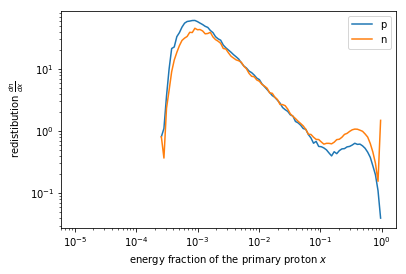

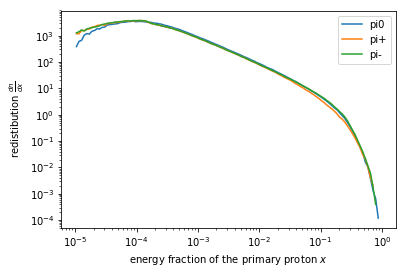

In [13]:
n_events = 100000

# at the delta resonance
epsilon = 1.5e-7

angle = 180.
hlist = run_sophia(2112, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
print_multiplicities(hlist, pids_print = [2212,2112,-2212,-2112])

plot_redistribution(hlist)
plt.show()
plot_redistribution(hlist, pids_plot = [211,-211,111])
plt.show()


# at high energy (multipion)
epsilon = 2e-5
angle = 180.

hlist = run_sophia(2112, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
print_multiplicities(hlist, pids_print = [2212,2112,-2212,-2112])

plot_redistribution(hlist)
plt.show()
plot_redistribution(hlist, pids_plot = [211,-211,111])
plt.show()


# even higher energy (multipion)
epsilon = 1e-3
angle = 180.

hlist = run_sophia(2112, epsilon, e_mother = 1e6, theta = angle, n_events = n_events)
print_multiplicities(hlist, pids_print = [2212,2112,-2212,-2112])

plot_redistribution(hlist)
plt.show()
plot_redistribution(hlist, pids_plot = [211,-211,111])
plt.show()


# Now the actual sampling

The actual sampling is done here. We want the redistribution into secondaries on an energy grid in $\epsilon_r$, that is sufficiently dense.

The distributions will be sampled in $x$ and in $\epsilon_r$

This is sufficient, as the redistribution is universal and can be scaled for different $E_p$ and $\theta$, as long as $E_p >> \epsilon$

In [14]:
# set up even generator
srun = SophiaCascadeRun('sophia12','Sophia',0,
                        10000, # events 
                        fill_subset=False)

# list of stable particles
ptab = srun.ptab
part_name = lambda ev: [ptab.modid2modname[pid] for pid in ev.p_ids]

# stable_part = [ptab.modid2modname[pid] for pid in range(1,21) if pid != 12]
# stable_ids = [pid for pid in range(1,21) if pid != 12]

stable_part = [ptab.modid2modname[pid] for pid in range(1,4) + range(13,21) if pid != 14]
stable_ids = [pid for pid in range(1,4) + range(13,21) if pid != 14]

for tup in zip(stable_part,stable_ids):
    print tup

sophia12
stable, 1
stable, 2
stable, 3
stable, 4
stable, 5
stable, 6
stable, 7
stable, 8
stable, 9
stable, 10
stable, 11
stable, 13
stable, 14
stable, 15
stable, 16
stable, 17
stable, 18
stable, 19
stable, 20
SophiaCascadeRun::init_generator(): seed= 8741204
('gamma', 1)
('e+', 2)
('e-', 3)
('p', 13)
('nue', 15)
('antinue', 16)
('numu', 17)
('antinumu', 18)
('nutau', 19)
('antinutau', 20)


In [15]:
def set_up_hists_sample(stable_ids, x_sample, e_mother):
    h_list = []

    for stable_id in stable_ids:
        h_list.append(
            EnergySpectrum(
                stable_id, ptab.modid2pdg[stable_id],
                e_mother, 'x', 
                title='some random title',
                x_bins = x_sample))

        if stable_id in ptab.baryon_range:
            h_list.append(EnergySpectrum(
                -stable_id, ptab.modid2pdg[-stable_id],
                e_mother, 'x', 
                title='some random title',
                x_bins = x_sample))
    
    return h_list

In [16]:
def run_sophia_sample(mother_id, epsr_list, x_sample, n_events, theta = 180., e_mother = 1e6, rand_theta = False ):
    masses = {
    2212: 0.93827,
    2112: 0.93957
    }
    mass = masses[mother_id]
    y_list = epsr_list / (1 - np.cos(np.pi * theta / 180.))
    eps_list = mass * y_list / e_mother
    
    results = []
    for epsilon in eps_list:
        #print 'rest frame photon energy: {:} GeV, with y = {:} and eps/Ep = {:}'.format(e_rest,y, epsilon/e_mother)
        #s = 2 * mass * e_rest + mass**2
        #print 'center of mass: s = {:}, gamma_s = {:}'.format(s, (e_mother + epsilon) / np.sqrt(s))
    
        srun.spectrum_hists = set_up_hists_sample(stable_ids, x_sample, e_mother)
        srun.nEvents = n_events
        print 'running {:} events for particle {:}, at epsilon = {:}'.format(n_events, ptab.pdg2modname[mother_id], epsilon)
        print '--'*10
        srun.start(mother_id, e_mother, epsilon, theta, rand_theta = rand_theta)
        
        results.append(srun.spectrum_hists)
    
    return results

In [17]:
# functions to check for consistency after running the sample

def check_sample(sample, epsr_list):
    """
    checks the sample for baryon number and energy conservation
    """  
    for h_list, epsr in zip(sample,epsr_list):
        # energy conservation and baryon number
        etotal = 0.
        baryon_number = 0.
        for h in h_list:
            bin_widths = (h.x_bins[1:] - h.x_bins[:-1])
            bin_center = 0.5 * (h.x_bins[1:] + h.x_bins[:-1])
            particles = h.get().dot(bin_widths)
            energy = (h.get() * bin_center).dot(bin_widths)
            if h.pdg_id in [2212, 2112]:
                print 'p_id', h.pdg_id, 'has multiplicity', particles, 'and energy', energy
            etotal += energy
            if h.pdg_id in [2212,2112]:
                baryon_number += particles
            if h.pdg_id in [-2212,-2112]:
                baryon_number -= particles
        print '-----------------------------'
        print 'at energy eps_r', epsr
        print 'baryon number:', baryon_number
        print 'energy conservation:', etotal
        print '-----------------------------'

def check_sample_plots(sample, epsr_list):
    """
    produces plots for the sample showing total energy and brayon number as a functions of epsilon_r
    """    
    etotal_list = []
    baryon_number_list = []
    multiplicity_prot = []
    multiplicity_neutr = []
    multiplicity_pion = []
    
    for h_list, epsr in zip(sample,epsr_list):
        # energy conservation and baryon number
        etotal = 0.
        baryon_number = 0.
        for h in h_list:
            bin_widths = (h.x_bins[1:] - h.x_bins[:-1])
            bin_center = 0.5 * (h.x_bins[1:] + h.x_bins[:-1])
            particles = h.get().dot(bin_widths)
            energy = (h.get() * bin_center).dot(bin_widths)
                        
            if h.pdg_id == 2212:
                    multiplicity_prot.append(particles)
            if h.pdg_id == 2112:
                    multiplicity_neutr.append(particles)
            if h.pdg_id in [211]:
                    multiplicity_pion.append(particles)
            
            etotal += energy
            if h.pdg_id in [2212,2112]:
                baryon_number += particles
            if h.pdg_id in [-2212,-2112]:
                baryon_number -= particles

        etotal_list.append(etotal)
        baryon_number_list.append(baryon_number)
    
    plt.semilogx(epsr_list, etotal_list, label = 'total energy')
    plt.semilogx(epsr_list, baryon_number_list, label = 'baryon number')
    plt.legend()
    plt.xlabel(r'photon energy in the rest fram $\epsilon_r$')
    plt.ylabel(r'energy fraction / baryon number')    
    
    twin = plt.gca().twinx()
    twin.semilogx(epsr_list,csec_proton,alpha =0.4,c='red')
    plt.ylabel(r'cross section')
    plt.show()
    
    plt.semilogx(epsr_list, multiplicity_prot, label = 'protons')
    plt.semilogx(epsr_list, multiplicity_neutr, label = 'neutrons')
    plt.semilogx(epsr_list, multiplicity_pion, label = 'pi_plus')
    plt.legend()
    plt.xlabel(r'photon energy in the rest fram $\epsilon_r$')
    plt.ylabel(r'multiplicity')
    
    twin = plt.gca().twinx()
    twin.semilogx(epsr_list,csec_proton,alpha =0.4,c='red')
    plt.ylabel(r'cross section')
    plt.show()
    

def check_sample_plots_highE(sample, epsr_list):
    """
    same as check_sample_plots, but the does only count particles with x > 2e-2
    """
    
    etotal_list = []
    baryon_number_list = []
    multiplicity_prot = []
    multiplicity_neutr = []
    multiplicity_pion = []
    
    print 'starting'
    for h_list, epsr in zip(sample,epsr_list):
        # energy conservation and baryon number
        etotal = 0.
        baryon_number = 0.
        pion_multi = 0.
        for h in h_list:
            bin_widths = (h.x_bins[1:] - h.x_bins[:-1])
            bin_center = 0.5 * (h.x_bins[1:] + h.x_bins[:-1])
            
            x_values = bin_center[bin_center > 2e-2]
            x_width = bin_widths[bin_center > 2e-2]
            y_values = h.get()
            y_values = y_values[bin_center > 2e-2]
          
            particles = y_values.dot(x_width)
            energy = (y_values * x_values).dot(x_width)
            
            if h.pdg_id == 2212:
                    multiplicity_prot.append(particles)
            if h.pdg_id == 2112:
                    multiplicity_neutr.append(particles)
            if h.pdg_id in [211,-211,111]:
                    pion_multi += particles
            
            etotal += energy
            if h.pdg_id in [2212,2112]:
                baryon_number += particles
            if h.pdg_id in [-2212,-2112]:
                baryon_number -= particles
            
        etotal_list.append(etotal)
        baryon_number_list.append(baryon_number)
        multiplicity_pion.append(pion_multi)
    
    plt.semilogx(epsr_list, etotal_list, label = 'total energy')
    plt.semilogx(epsr_list, baryon_number_list, label = 'baryon number')
    plt.legend()
    plt.xlabel(r'photon energy in the rest fram $\epsilon_r$')
    plt.ylabel(r'energy fraction / baryon number')    
    
    twin = plt.gca().twinx()
    twin.semilogx(epsr_list,csec_proton,alpha =0.4,c='red')
    plt.ylabel(r'cross section')
    plt.show()
    
    plt.semilogx(epsr_list, multiplicity_prot, label = 'protons')
    plt.semilogx(epsr_list, multiplicity_neutr, label = 'neutrons')
    plt.semilogx(epsr_list, multiplicity_pion, label = 'pi_plus')
    plt.legend()
    plt.xlabel(r'photon energy in the rest fram $\epsilon_r$')
    plt.ylabel(r'multiplicity')
    
    twin = plt.gca().twinx()
    twin.semilogx(epsr_list,csec_proton,alpha =0.4,c='red')
    plt.ylabel(r'cross section')
    plt.show()

## run large sample

In [18]:
import cPickle as pickle

In [19]:
def get_bins_and_width_from_centers_lin(vector):

    vector_log = vector

    steps = vector_log[1] - vector_log[0]

    bins_log = vector_log - 0.5 * steps

    bins_log = np.resize(bins_log, vector_log.size + 1)

    bins_log[-1] = vector_log[-1] + 0.5 * steps

    bins = bins_log

    widths = bins[1:] - bins[:-1]

    return bins, widths

In [20]:
def get_bins_and_width_from_centers(vector):

    vector_log = np.log10(vector)

    steps = vector_log[1] - vector_log[0]

    bins_log = vector_log - 0.5 * steps

    bins_log = np.resize(bins_log, vector_log.size + 1)

    bins_log[-1] = vector_log[-1] + 0.5 * steps

    bins = 10**bins_log

    widths = bins[1:] - bins[:-1]

    return bins, widths

In [21]:
def plot_redistribution(h_list, pids_plot = [2212,2112]):
    """
    plot the redistribution from h_list for the particles in pids_plot
    """
    
    for h in h_list:
        bin_centers = 0.5*(h.x_bins[1:] + h.x_bins[:-1])
        if h.pdg_id in pids_plot:
            plt.loglog(bin_centers, h.get(), label = ptab.pdg2modname[h.pdg_id])
    plt.legend()
    plt.xlabel('energy fraction of the primary proton $x$')
    plt.ylabel(r'redistibution $\frac{d n}{d x}$')

In [22]:
# setup the list of eps_r values and the binnng in x

epsr_list = np.unique(np.concatenate( (np.logspace(-0.8,0.3,120),np.logspace(0.3,8,40)) )) # epsilon_r values to sample at
# x_bins = np.logspace(-8,0,81)
x_bins=get_bins_and_width_from_centers(np.logspace(-8,0,160))[0]

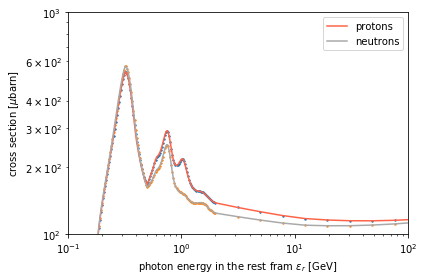

In [43]:
srun.lib.initial(13)
csec_proton  = np.array([srun.lib.crossection(epsr,3,13) for epsr in epsr_list])
srun.lib.initial(14)
csec_neutron = np.array([srun.lib.crossection(epsr,3,14) for epsr in epsr_list])

fig = plt.figure()

plt.loglog(epsr_list,csec_proton, label = 'protons', color = 'tomato')
plt.scatter(epsr_list,csec_proton, s=2.)
plt.loglog(epsr_list,csec_neutron, label = 'neutrons', color = 'darkgray')
plt.scatter(epsr_list,csec_neutron, s=2.)
plt.xlim(1e-1,1e2)
plt.ylim(1e2,1e3)

plt.legend()

plt.xlabel(r'photon energy in the rest fram $\epsilon_r$ [GeV]')
plt.ylabel(r'cross section [$\mu$barn]')

plt.tight_layout()
fig.savefig('/home/jheinze/cross_section_sophia_grid.png', dpi=200)

In [70]:
print len(epsr_list)
print len(x_bins)

159
161


In [24]:
%%time

lower = 5.
upper = 14.
bins_dec = 8
bins = np.logspace(lower, upper, (upper - lower) * bins_dec + 1)
centers = (bins[1:] + bins[:-1])/2
bins /= centers[-1]

sample_proton = run_sophia_sample(2212, epsr_list, x_bins, 2000000, e_mother = 1e10)
with open('../temp_files/sophia_sample_proton_8binsperdec.ppo','wb') as file:
    pickle.dump((sample_proton,epsr_list,x_bins), file, protocol=-1)

running 2000000 events for particle p, at epsilon = 7.43528867845e-12
--------------------
running 2000000 events for particle p, at epsilon = 7.59524053815e-12
--------------------
running 2000000 events for particle p, at epsilon = 7.75863336678e-12
--------------------
running 2000000 events for particle p, at epsilon = 7.9255411883e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.0960396191e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.27020590224e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.44811894252e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.62985934214e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.8155094373e-12
--------------------
running 2000000 events for particle p, at epsilon = 9.00515333542e-12
--------------------
running 2000000 events for particle p, at epsilon = 9.19887695331e-12
--------------------
ru

running 2000000 events for particle p, at epsilon = 5.15791647935e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.26887630467e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.38222315641e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.49800838552e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.61628444768e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.73710492699e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.86052456031e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.98659926202e-11
--------------------
running 2000000 events for particle p, at epsilon = 6.11538614933e-11
--------------------
running 2000000 events for particle p, at epsilon = 6.24694356824e-11
--------------------
running 2000000 events for particle p, at epsilon = 6.38133111986e-11
--------------------

In [25]:
%%time

lower = 5.
upper = 14.
bins_dec = 8
bins = np.logspace(lower, upper, (upper - lower) * bins_dec + 1)
centers = (bins[1:] + bins[:-1])/2
bins /= centers[-1]

sample_proton = run_sophia_sample(2112, epsr_list, x_bins, 2000000, e_mother = 1e10)
with open('../temp_files/sophia_sample_neutron_8binsperdec.ppo','wb') as file:
    pickle.dump((sample_proton,epsr_list,x_bins), file, protocol=-1)

running 2000000 events for particle n, at epsilon = 7.4455904842e-12
--------------------
running 2000000 events for particle n, at epsilon = 7.60576396179e-12
--------------------
running 2000000 events for particle n, at epsilon = 7.76938317588e-12
--------------------
running 2000000 events for particle n, at epsilon = 7.93652225297e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.10725691423e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.28166450975e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.45982405365e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.64181625982e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.82772357851e-12
--------------------
running 2000000 events for particle n, at epsilon = 9.01763023369e-12
--------------------
running 2000000 events for particle n, at epsilon = 9.21162226121e-12
--------------------


running 2000000 events for particle n, at epsilon = 5.16506292059e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.27617648394e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.38968038098e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.50562603385e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.62406597089e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.74505385044e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.8686444852e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.99489386702e-11
--------------------
running 2000000 events for particle n, at epsilon = 6.12385919227e-11
--------------------
running 2000000 events for particle n, at epsilon = 6.25559888775e-11
--------------------
running 2000000 events for particle n, at epsilon = 6.39017263718e-11
--------------------


In [17]:
%%time
x_centers=np.logspace(-8,0,16)
x_bins=get_bins_and_width_from_centers(x_centers)[0]

sample_proton = run_sophia_sample(2212, epsr_list, x_bins, 50000, e_mother = 1e10)
with open('../temp_files/sophia_sample_proton_fewerbins.ppo','wb') as file:
    pickle.dump((sample_proton,epsr_list,x_bins), file, protocol=-1)

running 50000 events for particle p, at epsilon = 7.43528867845e-12
--------------------
running 50000 events for particle p, at epsilon = 7.59524053815e-12
--------------------
running 50000 events for particle p, at epsilon = 7.75863336678e-12
--------------------
running 50000 events for particle p, at epsilon = 7.9255411883e-12
--------------------
running 50000 events for particle p, at epsilon = 8.0960396191e-12
--------------------
running 50000 events for particle p, at epsilon = 8.27020590224e-12
--------------------
running 50000 events for particle p, at epsilon = 8.44811894252e-12
--------------------
running 50000 events for particle p, at epsilon = 8.62985934214e-12
--------------------
running 50000 events for particle p, at epsilon = 8.8155094373e-12
--------------------
running 50000 events for particle p, at epsilon = 9.00515333542e-12
--------------------
running 50000 events for particle p, at epsilon = 9.19887695331e-12
--------------------
running 50000 events for

running 50000 events for particle p, at epsilon = 5.38222315641e-11
--------------------
running 50000 events for particle p, at epsilon = 5.49800838552e-11
--------------------
running 50000 events for particle p, at epsilon = 5.61628444768e-11
--------------------
running 50000 events for particle p, at epsilon = 5.73710492699e-11
--------------------
running 50000 events for particle p, at epsilon = 5.86052456031e-11
--------------------
running 50000 events for particle p, at epsilon = 5.98659926202e-11
--------------------
running 50000 events for particle p, at epsilon = 6.11538614933e-11
--------------------
running 50000 events for particle p, at epsilon = 6.24694356824e-11
--------------------
running 50000 events for particle p, at epsilon = 6.38133111986e-11
--------------------
running 50000 events for particle p, at epsilon = 6.51860968753e-11
--------------------
running 50000 events for particle p, at epsilon = 6.65884146429e-11
--------------------
running 50000 events 

In [51]:
%%time
x_centers=np.logspace(-8,0,160)
x_bins=get_bins_and_width_from_centers(x_centers)[0]

sample_proton = run_sophia_sample(2212, epsr_list, x_bins, 2000000, e_mother = 1e10)
with open('../temp_files/sophia_sample_proton_logbins.ppo','wb') as file:
    pickle.dump((sample_proton,epsr_list,x_bins), file, protocol=-1)

running 2000000 events for particle p, at epsilon = 7.43528867845e-12
--------------------


KeyError: 14

In [16]:
%%time
x_centers=np.logspace(-8,0,160)
x_bins=get_bins_and_width_from_centers_lin(x_centers)[0]

sample_proton = run_sophia_sample(2212, epsr_list, x_bins,2000000, e_mother = 1e10)
with open('../temp_files/sophia_sample_proton_unsable_neutron.ppo','wb') as file:
    pickle.dump((sample_proton,epsr_list,x_bins), file, protocol=-1)

running 2000000 events for particle p, at epsilon = 7.43528867845e-12
--------------------


KeyError: 14

In [26]:
%%time
x_centers=np.logspace(-8,-1,120)
x_bins1=get_bins_and_width_from_centers(x_centers)[0]
x_centers=np.linspace(0.1,1.,40)
x_bins2=get_bins_and_width_from_centers_lin(x_centers)[0]
x_bins=np.unique(np.concatenate((x_bins1,x_bins2)))

sample_proton = run_sophia_sample(2212, epsr_list, x_bins,2000000, e_mother = 1e10)
with open('../temp_files/sophia_sample_proton_mixbins.ppo','wb') as file:
    pickle.dump((sample_proton,epsr_list,x_bins), file, protocol=-1)

running 2000000 events for particle p, at epsilon = 7.43528867845e-12
--------------------
running 2000000 events for particle p, at epsilon = 7.59524053815e-12
--------------------
running 2000000 events for particle p, at epsilon = 7.75863336678e-12
--------------------
running 2000000 events for particle p, at epsilon = 7.9255411883e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.0960396191e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.27020590224e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.44811894252e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.62985934214e-12
--------------------
running 2000000 events for particle p, at epsilon = 8.8155094373e-12
--------------------
running 2000000 events for particle p, at epsilon = 9.00515333542e-12
--------------------
running 2000000 events for particle p, at epsilon = 9.19887695331e-12
--------------------
ru

running 2000000 events for particle p, at epsilon = 5.15791647935e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.26887630467e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.38222315641e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.49800838552e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.61628444768e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.73710492699e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.86052456031e-11
--------------------
running 2000000 events for particle p, at epsilon = 5.98659926202e-11
--------------------
running 2000000 events for particle p, at epsilon = 6.11538614933e-11
--------------------
running 2000000 events for particle p, at epsilon = 6.24694356824e-11
--------------------
running 2000000 events for particle p, at epsilon = 6.38133111986e-11
--------------------

KeyboardInterrupt: 

In [18]:
%%time
x_centers=np.logspace(-8,0,16)
x_bins=get_bins_and_width_from_centers(x_centers)[0]

sample_neutron = run_sophia_sample(2112, epsr_list, x_bins,50000, e_mother = 1e10)
with open('../temp_files/sophia_sample_neutron_fewerbins.ppo','wb') as file:
    pickle.dump((sample_neutron,epsr_list,x_bins), file, protocol=-1)

running 50000 events for particle n, at epsilon = 7.4455904842e-12
--------------------
running 50000 events for particle n, at epsilon = 7.60576396179e-12
--------------------
running 50000 events for particle n, at epsilon = 7.76938317588e-12
--------------------
running 50000 events for particle n, at epsilon = 7.93652225297e-12
--------------------
running 50000 events for particle n, at epsilon = 8.10725691423e-12
--------------------
running 50000 events for particle n, at epsilon = 8.28166450975e-12
--------------------
running 50000 events for particle n, at epsilon = 8.45982405365e-12
--------------------
running 50000 events for particle n, at epsilon = 8.64181625982e-12
--------------------
running 50000 events for particle n, at epsilon = 8.82772357851e-12
--------------------
running 50000 events for particle n, at epsilon = 9.01763023369e-12
--------------------
running 50000 events for particle n, at epsilon = 9.21162226121e-12
--------------------
running 50000 events f

running 50000 events for particle n, at epsilon = 5.38968038098e-11
--------------------
running 50000 events for particle n, at epsilon = 5.50562603385e-11
--------------------
running 50000 events for particle n, at epsilon = 5.62406597089e-11
--------------------
running 50000 events for particle n, at epsilon = 5.74505385044e-11
--------------------
running 50000 events for particle n, at epsilon = 5.8686444852e-11
--------------------
running 50000 events for particle n, at epsilon = 5.99489386702e-11
--------------------
running 50000 events for particle n, at epsilon = 6.12385919227e-11
--------------------
running 50000 events for particle n, at epsilon = 6.25559888775e-11
--------------------
running 50000 events for particle n, at epsilon = 6.39017263718e-11
--------------------
running 50000 events for particle n, at epsilon = 6.52764140824e-11
--------------------
running 50000 events for particle n, at epsilon = 6.66806748016e-11
--------------------
running 50000 events f

In [49]:
%%time
x_centers=np.logspace(-8,0,160)
x_bins=get_bins_and_width_from_centers(x_centers)[0]

sample_neutron = run_sophia_sample(2112, epsr_list, x_bins,2000000, e_mother = 1e10)
with open('../temp_files/sophia_sample_neutron_linbins.ppo','wb') as file:
    pickle.dump((sample_neutron,epsr_list,x_bins), file, protocol=-1)

running 2000000 events for particle n, at epsilon = 7.4455904842e-12
--------------------


KeyError: 8

In [106]:
%%time
x_centers=np.linspace(0.01,1.,160)
x_bins=get_bins_and_width_from_centers_lin(x_centers)[0]

print x_bins
sample_neutron = run_sophia_sample(2112, epsr_list, x_bins,2000000, e_mother = 1e10)
with open('../temp_files/sophia_sample_neutron_linbins.ppo','wb') as file:
    pickle.dump((sample_neutron,epsr_list,x_bins), file, protocol=-1)

[ 0.00688679  0.01311321  0.01933962  0.02556604  0.03179245  0.03801887
  0.04424528  0.0504717   0.05669811  0.06292453  0.06915094  0.07537736
  0.08160377  0.08783019  0.0940566   0.10028302  0.10650943  0.11273585
  0.11896226  0.12518868  0.13141509  0.13764151  0.14386792  0.15009434
  0.15632075  0.16254717  0.16877358  0.175       0.18122642  0.18745283
  0.19367925  0.19990566  0.20613208  0.21235849  0.21858491  0.22481132
  0.23103774  0.23726415  0.24349057  0.24971698  0.2559434   0.26216981
  0.26839623  0.27462264  0.28084906  0.28707547  0.29330189  0.2995283
  0.30575472  0.31198113  0.31820755  0.32443396  0.33066038  0.33688679
  0.34311321  0.34933962  0.35556604  0.36179245  0.36801887  0.37424528
  0.3804717   0.38669811  0.39292453  0.39915094  0.40537736  0.41160377
  0.41783019  0.4240566   0.43028302  0.43650943  0.44273585  0.44896226
  0.45518868  0.46141509  0.46764151  0.47386792  0.48009434  0.48632075
  0.49254717  0.49877358  0.505       0.51122642  0.

running 2000000 events for particle n, at epsilon = 3.23380830395e-11
--------------------
running 2000000 events for particle n, at epsilon = 3.30337569729e-11
--------------------
running 2000000 events for particle n, at epsilon = 3.37443966117e-11
--------------------
running 2000000 events for particle n, at epsilon = 3.44703239059e-11
--------------------
running 2000000 events for particle n, at epsilon = 3.52118677318e-11
--------------------
running 2000000 events for particle n, at epsilon = 3.59693640403e-11
--------------------
running 2000000 events for particle n, at epsilon = 3.67431560098e-11
--------------------
running 2000000 events for particle n, at epsilon = 3.75335942011e-11
--------------------
running 2000000 events for particle n, at epsilon = 3.83410367166e-11
--------------------
running 2000000 events for particle n, at epsilon = 3.91658493621e-11
--------------------
running 2000000 events for particle n, at epsilon = 4.00084058133e-11
--------------------

In [107]:
%%time
x_centers=np.logspace(-8,-1,120)
x_bins1=get_bins_and_width_from_centers(x_centers)[0]
x_centers=np.linspace(0.1,1.,40)
x_bins2=get_bins_and_width_from_centers_lin(x_centers)[0]
x_bins=np.unique(np.concatenate((x_bins1,x_bins2)))

sample_neutron = run_sophia_sample(2112, epsr_list, x_bins,2000000, e_mother = 1e10)
with open('../temp_files/sophia_sample_neutron_mixbins.ppo','wb') as file:
    pickle.dump((sample_neutron,epsr_list,x_bins), file, protocol=-1)

running 2000000 events for particle n, at epsilon = 7.4455904842e-12
--------------------
running 2000000 events for particle n, at epsilon = 7.60576396179e-12
--------------------
running 2000000 events for particle n, at epsilon = 7.76938317588e-12
--------------------
running 2000000 events for particle n, at epsilon = 7.93652225297e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.10725691423e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.28166450975e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.45982405365e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.64181625982e-12
--------------------
running 2000000 events for particle n, at epsilon = 8.82772357851e-12
--------------------
running 2000000 events for particle n, at epsilon = 9.01763023369e-12
--------------------
running 2000000 events for particle n, at epsilon = 9.21162226121e-12
--------------------


running 2000000 events for particle n, at epsilon = 5.16506292059e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.27617648394e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.38968038098e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.50562603385e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.62406597089e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.74505385044e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.8686444852e-11
--------------------
running 2000000 events for particle n, at epsilon = 5.99489386702e-11
--------------------
running 2000000 events for particle n, at epsilon = 6.12385919227e-11
--------------------
running 2000000 events for particle n, at epsilon = 6.25559888775e-11
--------------------
running 2000000 events for particle n, at epsilon = 6.39017263718e-11
--------------------


In [ ]:
print len(sample_proton)

print epsr_list.shape

print x_bins.shape

hist =  sample_proton[0][0]

In [ ]:
print hist.n_events_filled
print hist.buffer
print hist.n_entries

In [6]:
# functions to check for consistency after running the sample

def check_sample(sample, epsr_list):
    """
    checks the sample for baryon number and energy conservation
    """  
    for h_list, epsr in zip(sample,epsr_list):
        # energy conservation and baryon number
        etotal = 0.
        baryon_number = 0.
        for h in h_list:
            bin_widths = (h.x_bins[1:] - h.x_bins[:-1])
            bin_center = 0.5 * (h.x_bins[1:] + h.x_bins[:-1])
            particles = h.get().dot(bin_widths)
            energy = (h.get() * bin_center).dot(bin_widths)
            if h.pdg_id in [2212, 2112]:
                print 'p_id', h.pdg_id, 'has multiplicity', particles, 'and energy', energy
            etotal += energy
            if h.pdg_id in [2212,2112]:
                baryon_number += particles
            if h.pdg_id in [-2212,-2112]:
                baryon_number -= particles
        print '-----------------------------'
        print 'at energy eps_r', epsr
        print 'baryon number:', baryon_number
        print 'energy conservation:', etotal
        print '-----------------------------'

def check_sample_plots(sample, epsr_list):
    """
    produces plots for the sample showing total energy and brayon number as a functions of epsilon_r
    """    
    etotal_list = []
    baryon_number_list = []
    multiplicity_prot = []
    multiplicity_neutr = []
    multiplicity_pion = []
    
    for h_list, epsr in zip(sample,epsr_list):
        # energy conservation and baryon number
        etotal = 0.
        baryon_number = 0.
        for h in h_list:
            bin_widths = (h.x_bins[1:] - h.x_bins[:-1])
            bin_center = 0.5 * (h.x_bins[1:] + h.x_bins[:-1])

            particles = h.get().dot(bin_widths)
            energy = (h.get() * bin_center).dot(bin_widths)
                        
            if h.pdg_id == 2212:
                    multiplicity_prot.append(particles)
            if h.pdg_id == 2112:
                    multiplicity_neutr.append(particles)
            if h.pdg_id in [211]:
                    multiplicity_pion.append(particles)
            
            etotal += energy
            if h.pdg_id in [2212,2112]:
                baryon_number += particles
            if h.pdg_id in [-2212,-2112]:
                baryon_number -= particles

        etotal_list.append(etotal)
        baryon_number_list.append(baryon_number)
    
    plt.semilogx(epsr_list, etotal_list, label = 'total energy')
    plt.semilogx(epsr_list, baryon_number_list, label = 'baryon number')
    plt.legend()
    plt.xlabel(r'photon energy in the rest fram $\epsilon_r$')
    plt.ylabel(r'energy fraction / baryon number')    
    
    twin = plt.gca().twinx()
    twin.semilogx(epsr_list,csec_proton,alpha =0.4,c='red')
    plt.ylabel(r'cross section')
    plt.show()
    
    plt.semilogx(epsr_list, multiplicity_prot, label = 'protons')
    plt.semilogx(epsr_list, multiplicity_neutr, label = 'neutrons')
    plt.semilogx(epsr_list, multiplicity_pion, label = 'pi_plus')
    plt.legend()
    plt.xlabel(r'photon energy in the rest fram $\epsilon_r$')
    plt.ylabel(r'multiplicity')
    
    twin = plt.gca().twinx()
    twin.semilogx(epsr_list,csec_proton,alpha =0.4,c='red')
    plt.ylabel(r'cross section')
    plt.show()
    

def check_sample_plots_highE(sample, epsr_list):
    """
    same as check_sample_plots, but the does only count particles with x > 2e-2
    """
    
    etotal_list = []
    baryon_number_list = []
    multiplicity_prot = []
    multiplicity_neutr = []
    multiplicity_pion = []

    for h_list, epsr in zip(sample,epsr_list):
        # energy conservation and baryon number
        etotal = 0.
        baryon_number = 0.
        pion_multi = 0.
        for h in h_list:
            bin_widths = (h.x_bins[1:] - h.x_bins[:-1])
            bin_center = 0.5 * (h.x_bins[1:] + h.x_bins[:-1])

            x_values = bin_center[bin_center > 2e-2]
            x_width = bin_widths[bin_center > 2e-2]
            y_values = h.get()
            y_values = y_values[bin_center > 2e-2]
          
            particles = y_values.dot(x_width)
            energy = (y_values * x_values).dot(x_width)
            
            if h.pdg_id == 2212:
                    multiplicity_prot.append(particles)
            if h.pdg_id == 2112:
                    multiplicity_neutr.append(particles)
            if h.pdg_id in [211,-211,111]:
                    pion_multi += particles
            
            etotal += energy
            if h.pdg_id in [2212,2112]:
                baryon_number += particles
            if h.pdg_id in [-2212,-2112]:
                baryon_number -= particles
            
        etotal_list.append(etotal)
        baryon_number_list.append(baryon_number)
        multiplicity_pion.append(pion_multi)
    
    plt.semilogx(epsr_list, etotal_list, label = 'total energy')
    plt.semilogx(epsr_list, baryon_number_list, label = 'baryon number')
    plt.legend()
    plt.xlabel(r'photon energy in the rest fram $\epsilon_r$')
    plt.ylabel(r'energy fraction / baryon number')    
    
    twin = plt.gca().twinx()
    twin.semilogx(epsr_list,csec_proton,alpha =0.4,c='red')
    plt.ylabel(r'cross section')
    plt.show()
    
    plt.semilogx(epsr_list, multiplicity_prot, label = 'protons')
    plt.semilogx(epsr_list, multiplicity_neutr, label = 'neutrons')
    plt.semilogx(epsr_list, multiplicity_pion, label = 'pi_plus')
    plt.legend()
    plt.xlabel(r'photon energy in the rest fram $\epsilon_r$')
    plt.ylabel(r'multiplicity')
    
    twin = plt.gca().twinx()
    twin.semilogx(epsr_list,csec_proton,alpha =0.4,c='red')
    plt.ylabel(r'cross section')
    plt.show()

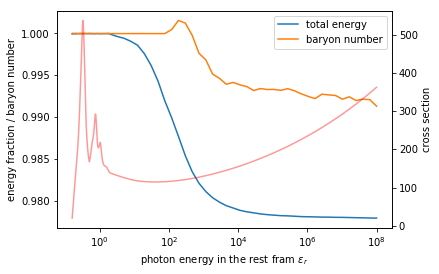

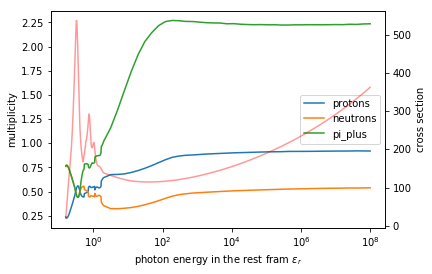

starting


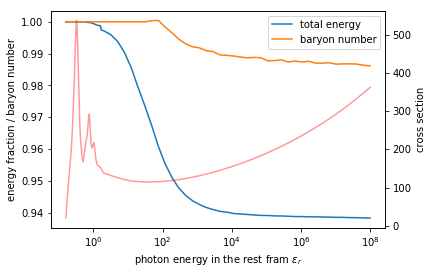

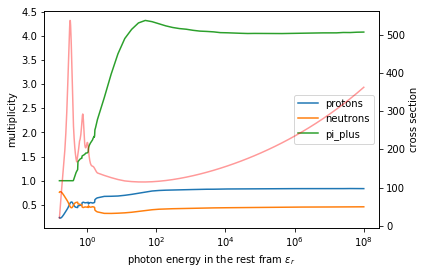

In [60]:
with open('../temp_files/sophia_sample_proton_linbins.ppo','rb') as file:
    sample_proton, epsr_list, x_bins = pickle.load(file)

fig = plt.figure()
check_sample_plots(sample_proton,epsr_list)
fig.savefig('/home/jheinze/conservation_proton_primary_linbins.png', dpi=200)

fig = plt.figure()
check_sample_plots_highE(sample_proton,epsr_list)
fig.savefig('/home/jheinze/multiplicity_proton_primary_linbins.png', dpi=200)



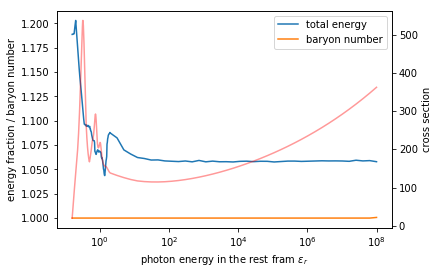

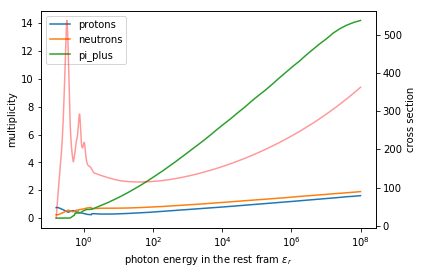

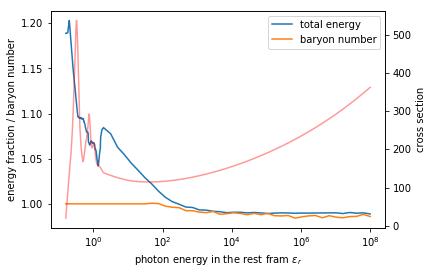

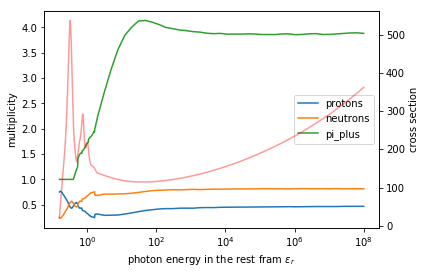

In [183]:
with open('../temp_files/sophia_sample_neutron_fewbins.ppo','rb') as file:
    sample_neutron, epsr_list, x_bins = pickle.load(file)
check_sample_plots(sample_neutron,epsr_list)
check_sample_plots_highE(sample_neutron,epsr_list)

In [44]:
def plot_redistribution(h_list, pids_plot = [2212,2112]):
    """
    plot the redistribution from h_list for the particles in pids_plot
    """
    
    for h in h_list:
#         bin_centers = 0.5*(h.x_bins[1:] + h.x_bins[:-1])
        bin_centers = 0.5*(np.log(h.x_bins[1:]) + np.log(h.x_bins[:-1]))
        bin_centers = np.exp(bin_centers)
        
#         print bin_centers
        if h.pdg_id in pids_plot:
            plt.loglog(bin_centers, h.get(), label = ptab.pdg2modname[h.pdg_id])
    plt.legend()
    plt.xlabel('energy fraction of the primary proton $x$')
    plt.ylabel(r'redistibution $\frac{d n}{d x}$')

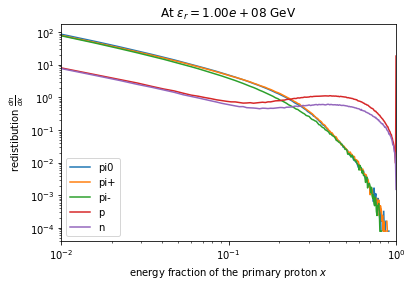

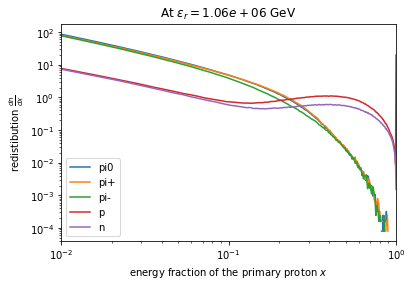

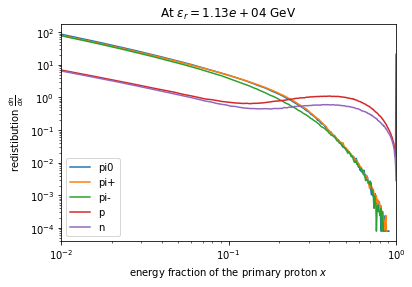

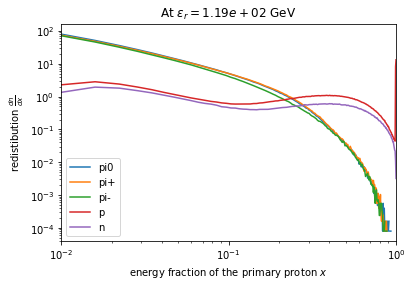

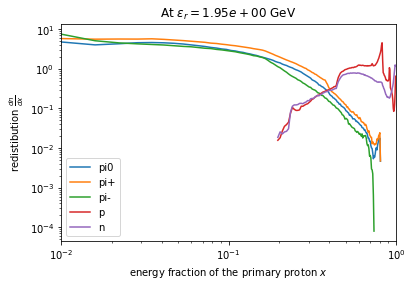

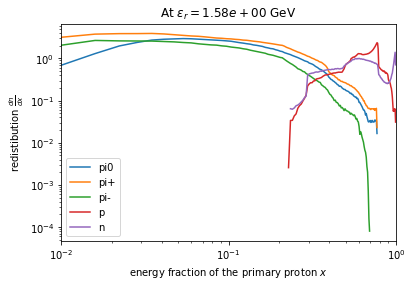

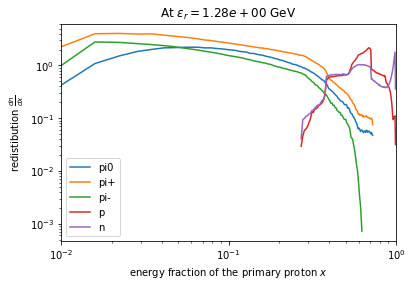

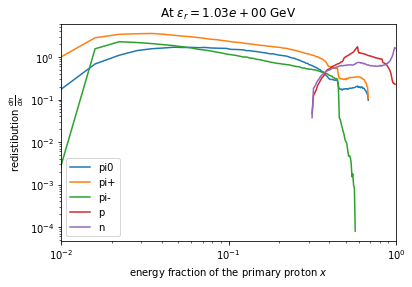

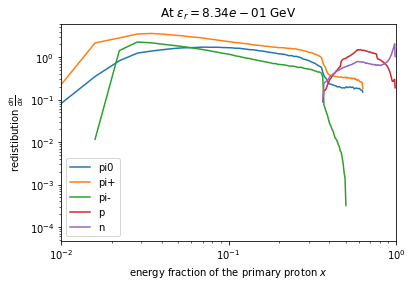

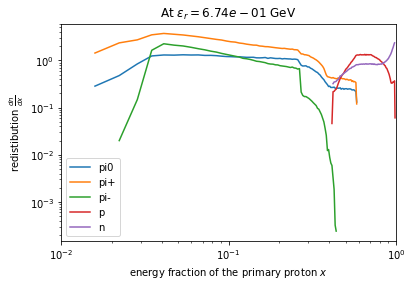

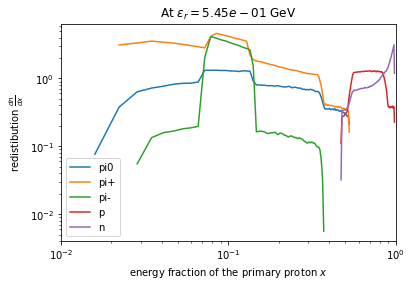

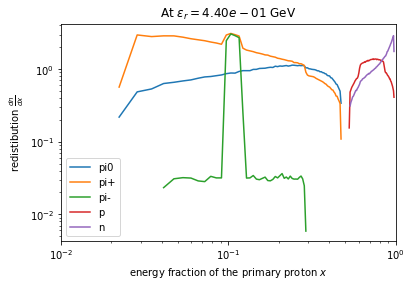

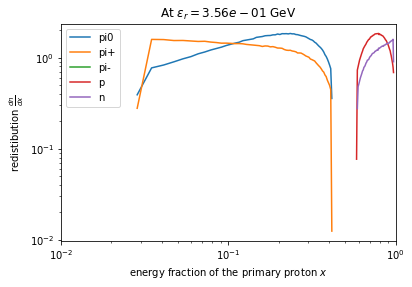

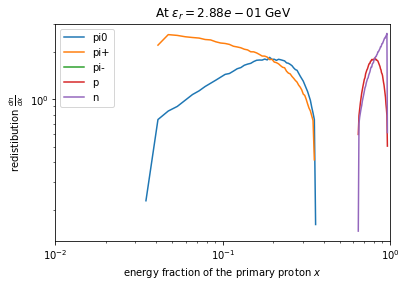

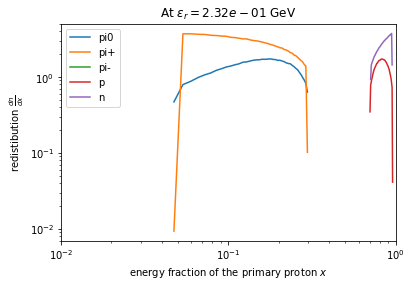

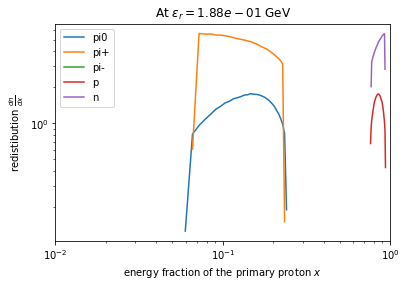

In [61]:
for hlist, eps in zip(sample_proton,epsr_list)[::-10]:
   #plot_redistribution(hlist, pids_plot = [2212,2112,-2212,-2112,211,-211,111,321,-321])
    fig = plt.figure()
#     plot_redistribution(hlist, pids_plot = [2212,2112,-2212,-2112,211,-211,111,321,-321])
    plot_redistribution(hlist, pids_plot = [2212,2112,211,-211,111])

    plt.title(r'At $\epsilon_r = {:3.2e}$ GeV'.format(eps))
    plt.xlim(1e-2,1e0)
    plt.show()
#     plt.tight_layout()
    fig.savefig('/home/jheinze/redistribution/redist_proton_linbins_{:3.2e}$ GeV.png'.format(eps), dpi=200)
    #plot_redistribution(hlist, pids_plot = [16,-16,14,-14,12,-12])
    #plt.show()
    #plot_redistribution(hlist, pids_plot = [22,-11,11,-13,13,321,-321,130])
    #plt.show()

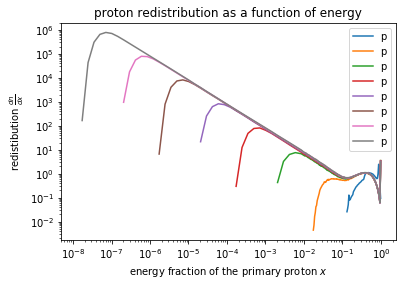

In [47]:
for hlist, eps in zip(sample_proton,epsr_list)[120::5]:
    plot_redistribution(hlist, pids_plot = [2212])
plt.title('proton redistribution as a function of energy')
#plt.xscale('linear')
#plt.yscale('linear')
#plt.ylim(0,3)
plt.show()

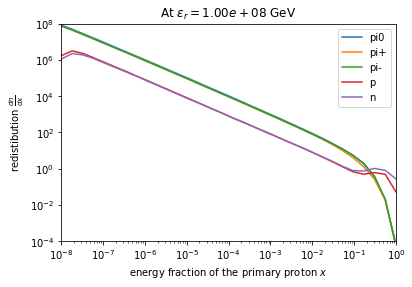

In [185]:
for hlist, eps in zip(sample_neutron,epsr_list)[-1::]:
    plot_redistribution(hlist, pids_plot = [2212,2112,211,-211,111])
    plt.title(r'At $\epsilon_r = {:3.2e}$ GeV'.format(eps))
    plt.xlim(1e-8,1e0)
    plt.ylim(1e-4,1e8)
#     plt.xscale('linear')
    plt.show()
    #plot_redistribution(hlist, pids_plot = [16,-16,14,-14,12,-12])
    #plt.show()

# Formatting for PriNCe

For PriNCe we want the data to be in a simple 2D array in $\epsilon_r$ and $x$

In [19]:
with open('../temp_files/sophia_sample_proton_fewerbins.ppo','rb') as file:
    sample_proton, epsr_list, x_bins = pickle.load(file)

with open('../temp_files/sophia_sample_neutron_fewerbins.ppo','rb') as file:
    sample_neutron, epsr_list, x_bins = pickle.load(file)

In [177]:
print epsr_list.shape
print x_bins.shape

print epsr_list.shape
print x_bins.shape

(159,)
(161,)
(159,)
(161,)


In [20]:
# For both samples get the values of the historgrams and write them into dictionaries

values = {}
for h_list in sample_proton:
    for h in h_list:
        da = h.pdg_id
        if da not in values:
            values[da] = [h.get()]
        else:
            values[da] += [h.get()]

redist_proton = {}
for da in values:
    redist_proton[da] = np.array(values[da])
    
values = {}
for h_list in sample_neutron:
    for h in h_list:
        da = h.pdg_id
        if da not in values:
            values[da] = [h.get()]
        else:
            values[da] += [h.get()]
            
redist_neutron = {}
for da in values:
    redist_neutron[da] = np.array(values[da])

    

# convert indices to NeuCosmA definitions:
id_mapping = [
    (0, 22),  # photon
    (2, 211),  # pi_plus
    (3, -211),  # pi_minus
    (4, 111),  # pi_zero
    (5, -13),  # mu_plus_l
    (6, -13),  # mu_plus_r
    (7, -13),  # mu_plus (both)
    (8, 13),  # mu_minus_l
    (9, 13),  # mu_minus_r
    (10, 13),  # mu_minus (both)
    (11, 12),  # nu_e
    (12, -12),  # nu_bar_e
    (13, 14),  # nu_mu
    (14, -14),  # nu_bar_mu
    (15, 16),  # nu_tau
    (16, -16),  # nu_bar_tau
    (20, 11),  # electron
    (21, -11),  # positron
    (50, 321),  # k_plus
    (51, -321),  # k_minus
    (100, 2112),  # neutron
    (101, 2212),  # proton
]
id_mapping_dict = {}
for nco_id, pdg_id in id_mapping:
    id_mapping_dict[pdg_id] = nco_id

# Now make new dicts with the NeuCosmA ids
# if NeuCosmA has no id for a particle, keep the old id
new_dict = {}
for da in redist_proton:
    if da in id_mapping_dict:
        da_new = id_mapping_dict[da]
        new_dict[da_new] = redist_proton[da]
    else:
        print 'da not in id-mapping', da
redist_proton = new_dict

new_dict = {}
for da in redist_neutron:
    if da in id_mapping_dict:
        da_new = id_mapping_dict[da]
        new_dict[da_new] = redist_neutron[da]
    else:
        print 'da not in id-mapping', da
redist_neutron = new_dict


np.save('../../data/sophia_redistribution_fewerbins.npy',(epsr_list,x_bins,redist_proton,redist_neutron))

da not in id-mapping 130
da not in id-mapping -2112
da not in id-mapping -2212
da not in id-mapping 130
da not in id-mapping -2112
da not in id-mapping -2212


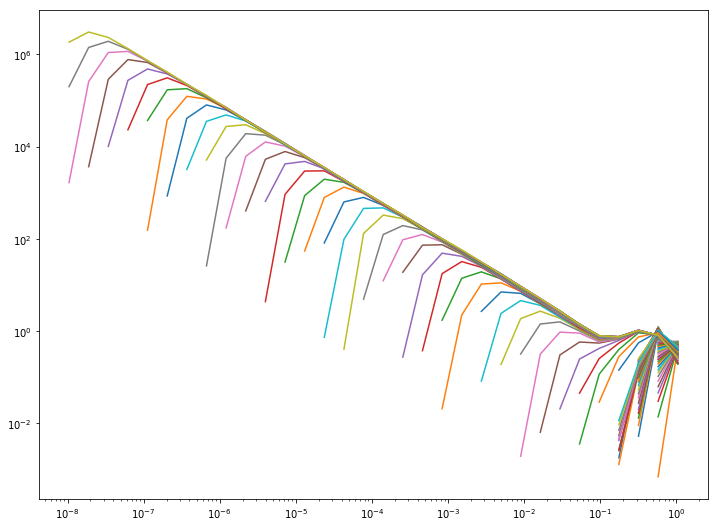

In [189]:
# plot to cross check

(epsr_list2,x_bins2,redist_proton2,redist_neutron2) = np.load('../../data/sophia_redistribution_fewbins.npy')

# epsr_list
# x_bins
# redist_proton
# redist_neutron

plt.figure(figsize=(12,9))
x = 0.5*(x_bins2[1:] + x_bins2[:-1])
for line in redist_proton2[101][::]:
    plt.loglog(x, line)

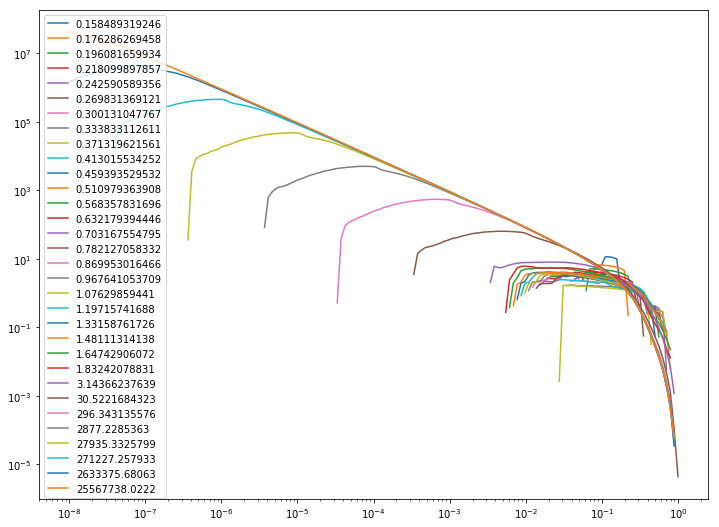

In [148]:
x = 0.5*(x_bins2[1:] + x_bins2[:-1])
y = epsr_list2

plt.figure(figsize=(12,9))
for line,yval in zip(redist_proton2[2],y)[::5]:
    plt.loglog(x, line, label = str(yval))
plt.legend()

In [96]:
x

array([  1.21255134e-08,   1.72801015e-08,   2.46259187e-08,
         3.50944625e-08,   5.00132123e-08,   7.12739624e-08,
         1.01572714e-07,   1.44751546e-07,   2.06285815e-07,
         2.93978466e-07,   4.18949496e-07,   5.97046046e-07,
         8.50851914e-07,   1.21255134e-06,   1.72801015e-06,
         2.46259187e-06,   3.50944625e-06,   5.00132123e-06,
         7.12739624e-06,   1.01572714e-05,   1.44751546e-05,
         2.06285815e-05,   2.93978466e-05,   4.18949496e-05,
         5.97046046e-05,   8.50851914e-05,   1.21255134e-04,
         1.72801015e-04,   2.46259187e-04,   3.50944625e-04,
         5.00132123e-04,   7.12739624e-04,   1.01572714e-03,
         1.44751546e-03,   2.06285815e-03,   2.93978466e-03,
         4.18949496e-03,   5.97046046e-03,   8.50851914e-03,
         1.01972873e-02,   1.05996464e-02,   1.10178816e-02,
         1.14526193e-02,   1.19045106e-02,   1.23742324e-02,
         1.28624883e-02,   1.33700095e-02,   1.38975562e-02,
         1.44459185e-02,

In [149]:
indices = np.array((19*3,26*3+2,32*3+2,38*3+2,46*3+2))
x[indices]

array([  7.39014158e-06,   1.06141559e-04,   8.54173002e-04,
         6.87394761e-03,   1.10854515e-01])

In [150]:
print [np.where(x==value) for value in [5.08116910e-01,2.53187721e-01,1.00018721e-01,4.98379634e-02,2.04647133e-02]]

[(array([], dtype=int64),), (array([], dtype=int64),), (array([], dtype=int64),), (array([], dtype=int64),), (array([], dtype=int64),)]


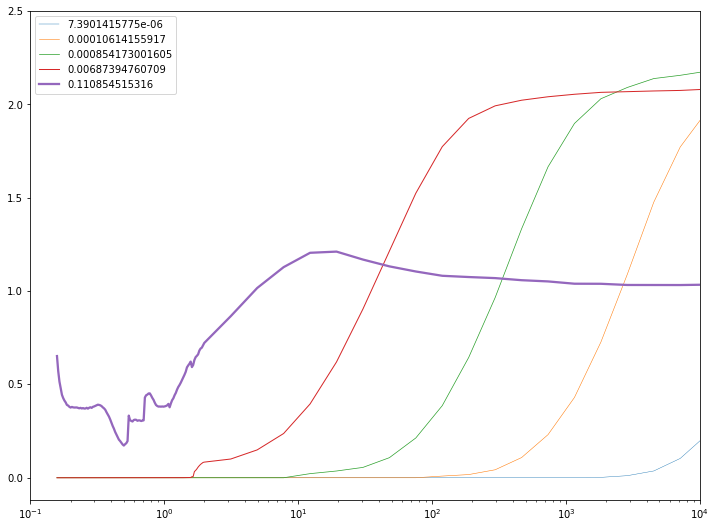

In [151]:
x = 0.5*(x_bins2[1:] + x_bins2[:-1])
y = epsr_list2

indices = np.array((19*3,26*3+2,32*3+2,38*3+2,46*3+2))

plt.figure(figsize=(12,9))
for redist,fraction in zip(redist_proton2[4].T[indices],x[indices]):
    redist = redist * fraction * np.log(10)
    plt.semilogx(y, redist,  linewidth = 1 / np.log(fraction) * 5, label = str(fraction))
plt.xlim(1e-1,1e4)
plt.legend()

In [152]:
import os
import sys
sys.path.append('../..')
import prince

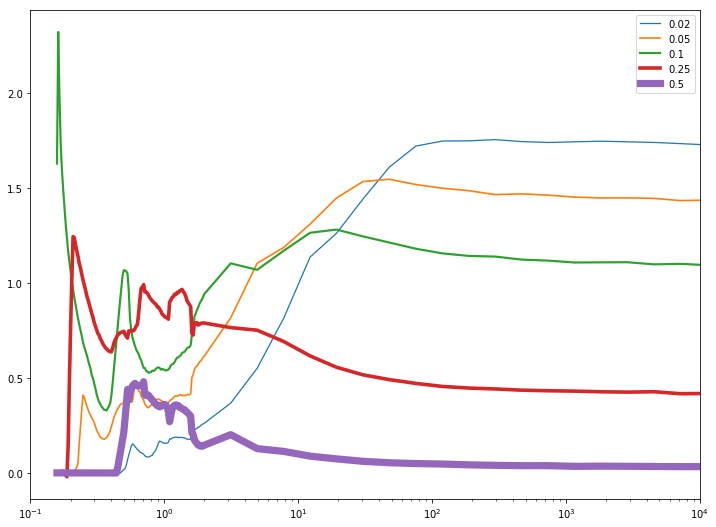

In [153]:
x = 0.5*(x_bins2[1:] + x_bins2[:-1])
y = epsr_list2

from prince.util import RectBivariateSplineNoExtrap
interpolated = RectBivariateSplineNoExtrap(x, y, redist_proton2[2].T)

plt.figure(figsize=(12,9))
for fraction in [0.02,0.05,0.1,0.25,0.5]:
    redist = interpolated(fraction, y, grid=False) * fraction * np.log(10)
    #print 'redist:', redist
    plt.semilogx(y, redist, linewidth = 1 / np.log(fraction) * 5, label = str(fraction))
plt.xlim(1e-1,1e4)
plt.legend()
#plt.ylim(0,2.5)

In [33]:
?RectBivariateSpline

In [29]:
redist_proton2[101].shape

(159, 158)

In [154]:
# also save the cross section, so we have it on the same grid as the redistribution

srun.lib.initial(13)
csec_proton  = np.array([srun.lib.crossection(epsr,3,13) for epsr in epsr_list])
srun.lib.initial(14)
csec_neutron = np.array([srun.lib.crossection(epsr,3,14) for epsr in epsr_list])

np.save('../../data/sophia_crosssec.npy',(epsr_list,csec_proton,csec_neutron))